# Loan Data from Prosper
## by Alaa Sayed

## Preliminary Wrangling

> This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [2]:
columns_from_prosper_dict = ['ListingKey','ListingCreationDate','Term','BorrowerAPR'
                             ,'LoanOriginalAmount','TotalProsperLoans','StatedMonthlyIncome']
date_cols = ['ListingCreationDate']

df = pd.read_csv('prosperLoanData.csv',parse_dates=date_cols)
df = df[columns_from_prosper_dict]
df.head()


,ListingKey,ListingCreationDate,Term,BorrowerAPR,LoanOriginalAmount,TotalProsperLoans,StatedMonthlyIncome
0,1021339766868145413AB3B,2007-08-26 19:09:29.263,36,0.16516,9425,NaN,3083.333333
1,10273602499503308B223C1,2014-02-27 08:28:07.900,36,0.12016,10000,NaN,6125.000000
2,0EE9337825851032864889A,2007-01-05 15:00:47.090,36,0.28269,3001,NaN,2083.333333
3,0EF5356002482715299901A,2012-10-22 11:02:35.010,36,0.12528,10000,NaN,2875.000000
4,0F023589499656230C5E3E2,2013-09-14 18:38:39.097,36,0.24614,15000,1.0,9583.333333


#### Based on <a href="https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0">prosper dictionary</a> , many of the columns originated after july 2009, so we will filter the older ones and do our analysis on the data from Sep 2009 to March 2014


In [3]:
import time
filter_date = time.strptime('01-08-09', '%d-%m-%y')
df =df[df.ListingCreationDate > "2009-08-08"]
df = df.sort_values(by=['ListingCreationDate'])
df.head()

,ListingKey,ListingCreationDate,Term,BorrowerAPR,LoanOriginalAmount,TotalProsperLoans,StatedMonthlyIncome
67089,96DD3460158345995084A9E,2009-08-08 05:20:57.390,36,0.24603,1000,1.0,5000.000000
43452,D2C9346066861048754F724,2009-08-08 09:37:03.793,36,0.12461,6000,1.0,7416.666667
50304,A6383458790992937C50139,2009-08-08 11:50:18.213,36,0.15094,3000,NaN,833.333333
99995,A5683459954014927728D9D,2009-08-08 13:00:17.903,36,0.12461,10000,NaN,9666.666667
27051,01563460938150757AB5E02,2009-08-08 13:14:38.850,36,0.18183,21000,NaN,4000.000000


#### Checking for duplicates:

In [4]:
sum(df.duplicated())

871

In [5]:
df.drop_duplicates(inplace=True)
sum(df.duplicated())

0

In [6]:
#  check for duplicated ids
duplicated_ids = 0
if(sum(df.ListingKey.duplicated())):
    df.drop_duplicates(subset='ListingKey', keep="first",inplace=True)
    duplicated_ids= duplicated_ids
    
print(f'found and removed %s ids'%duplicated_ids)

found and removed 0 ids


In [7]:
df= df.drop(columns=['ListingKey', 'ListingCreationDate'])
df= df.rename(columns={'BorrowerAPR':'APR','LoanOriginalAmount':'Amount','TotalProsperLoans':'Loans','StatedMonthlyIncome':'Income'})
df.head()

,Term,APR,Amount,Loans,Income
67089,36,0.24603,1000,1.0,5000.000000
43452,36,0.12461,6000,1.0,7416.666667
50304,36,0.15094,3000,NaN,833.333333
99995,36,0.12461,10000,NaN,9666.666667
27051,36,0.18183,21000,NaN,4000.000000


In [8]:
df.shape[0]

83737

### What is the structure of your dataset?

> the data consists of 83737 rows and  5 columns (Term , BorrowerAPR,StatedMonthlyIncome ,totalProsperLoans,LoanOriginalAmount)

### What is/are the main feature(s) of interest in your dataset?

> The main feature of interest is the BorrowerAPR.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> the variants that we expect should affect the interest rate are the loan's duration, the monthly income,number of other loans and of course the loan's amount.


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

#### a) We'll start by looking at the distribution of the main variable of interest: APR

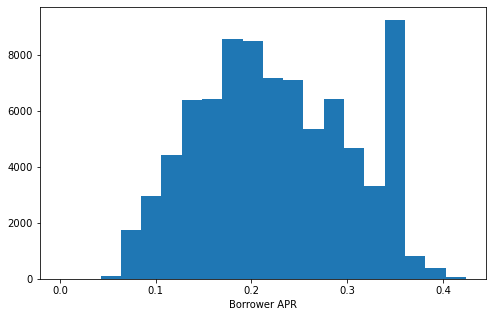

In [9]:
# start with a standard-scaled plot for APR
binsize = df['APR'].max()/20
bins = np.arange(0, df['APR'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'APR', bins = bins)
plt.xlabel('Borrower APR')
plt.show()

>There is clearly a large peak at 0.35 and the distribution looks multimodal(would have been normal if it wasn't for the peak at 0.35),
Next up, the first predictor variable of interest: StatedMonthlyIncome.

In [10]:
nan_rows = df[df['Income'].isnull()]
if(len(nan_rows)):
    print('filling {} Nan income values with 0'.format(len(nan_rows)))
    df.Income=df.Income.fillna(0)

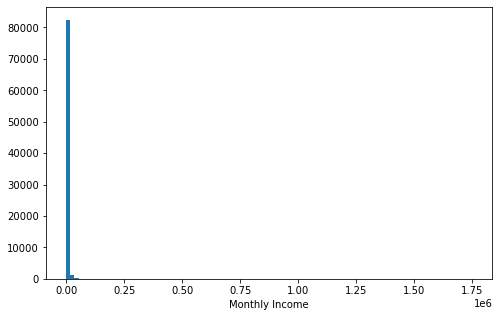

In [11]:
# plotting StatedMonthlyIncome on a standard scale
binsize = df['Income'].max()/100
bins = np.arange(0, df['Income'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'Income', bins = bins)
plt.xlabel('Monthly Income')
plt.show()

> Clearly there are outliers for the monthly income which we'll remove to adjust our data, from the observation, most of the incomes lies in the third of 250k (below 82k)

In [12]:
#starting from 85k we will remove outliers which are <0.5% of the population
ratio = 0.005
start = 85000
while(True):
    if ((df.Income>start).sum()/df.shape[0] < ratio):
        start = start - 100
    else:
        print('filtered data frame for incomes lower than {} which are {}% of the population'.format(start, 100*(df.Income>start).sum()/df.shape[0]))
        df = df[df.Income < start]
        break

filtered data frame for incomes lower than 24900 which are 0.6126324086126802% of the population


In [13]:
df.shape[0]

83224

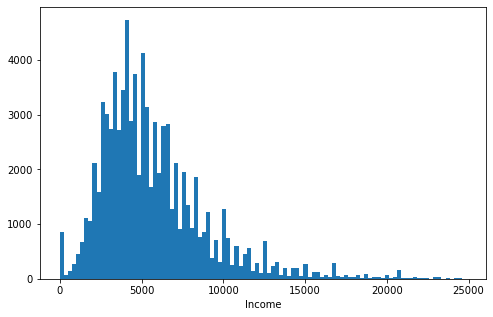

In [14]:
#redo the plot
# plotting StatedMonthlyIncome on a standard scale
binsize = df['Income'].max()/100
bins = np.arange(0, df['Income'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'Income', bins = bins)
plt.xlabel('Income')
plt.show()

> The distribution seems to be right skewed, now we investigate Loan amount 

In [15]:
nan_rows = df[df['Amount'].isnull()]
if(len(nan_rows)):
    print('Removed {} Nan Amount values'.format(len(nan_rows)))
    df=df[df.Amount.notna()]

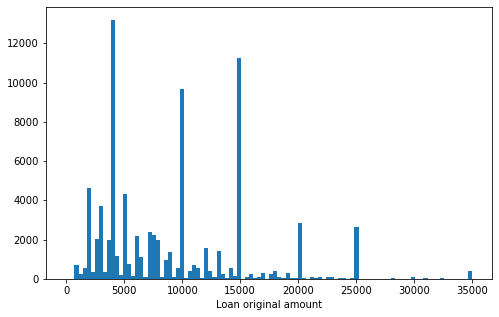

In [16]:
# plotting Amount on a standard scale
binsize = df['Amount'].max()/100
bins = np.arange(0, df['Amount'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = df, x = 'Amount', bins = bins)
plt.xlabel('Loan original amount')
plt.show()

> The data is multimodal having peaks at 3k,10k,15k,20k

In [17]:
df.Loans=df.Loans.fillna(0)
df.Loans.value_counts()

0.0    63870
1.0    13092
2.0     4305
3.0     1411
4.0      408
5.0      100
6.0       29
7.0        8
8.0        1
Name: Loans, dtype: int64

> We can remove outliers >5 loans

In [18]:
df=df[df.Loans<6]
df.Loans.value_counts()

0.0    63870
1.0    13092
2.0     4305
3.0     1411
4.0      408
5.0      100
Name: Loans, dtype: int64

In [19]:
#I didn't do this check on total loans as I knew from the dictionary that no loans might be filled with na
print("number of na in term column : " +str(sum(df.Term.value_counts())-df.shape[0]))
print(df.Term.value_counts())

number of na in term column : 0
36    57498
60    24091
12     1597
Name: Term, dtype: int64


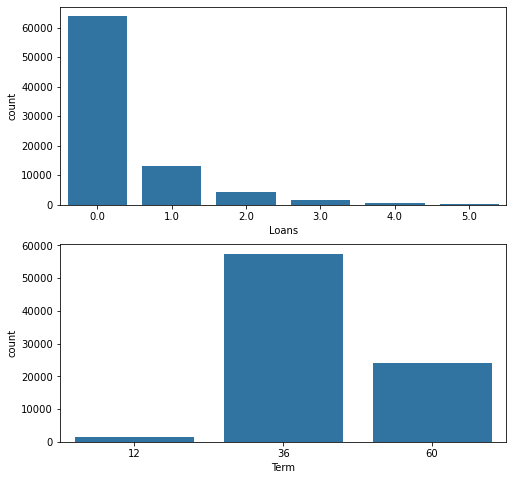

In [20]:
# let's plot the two together to get an idea of each ordinal variable's distribution.

fig, ax = plt.subplots(nrows=2, figsize = [8,8])

default_color = sb.color_palette()[0]
sb.countplot(data = df, x = 'Loans', color = default_color, ax = ax[0])
sb.countplot(data = df, x = 'Term', color = default_color, ax = ax[1])
plt.show()

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> We did not need to clear out any outliers, the distribution looks bimodal and there is a large peak at 0.35

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> to avoid outliers shadowing the real relationship for Monthly Income, they were cleared out, for TotalProsperLoans, insignificant outliers were removed.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

##### A) numeric variables

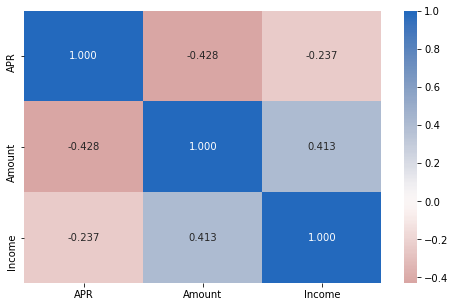

In [21]:
numeric_vars = ['APR','Amount','Income']
categoric_vars = ['Loans', 'Term']
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

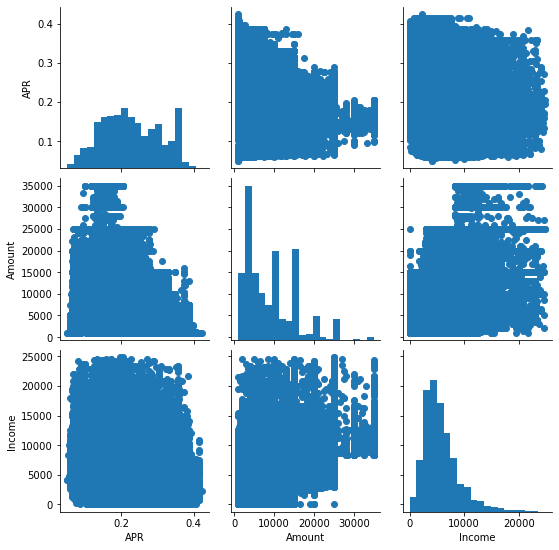

In [22]:
# plot matrix

g = sb.PairGrid(data = df, vars = numeric_vars)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)

##### Loan amount and monthly income are positively correlated while they both have negative correlation with the APR which makes sense.

##### B) categorical vs numeric variables

<Figure size 720x720 with 0 Axes>

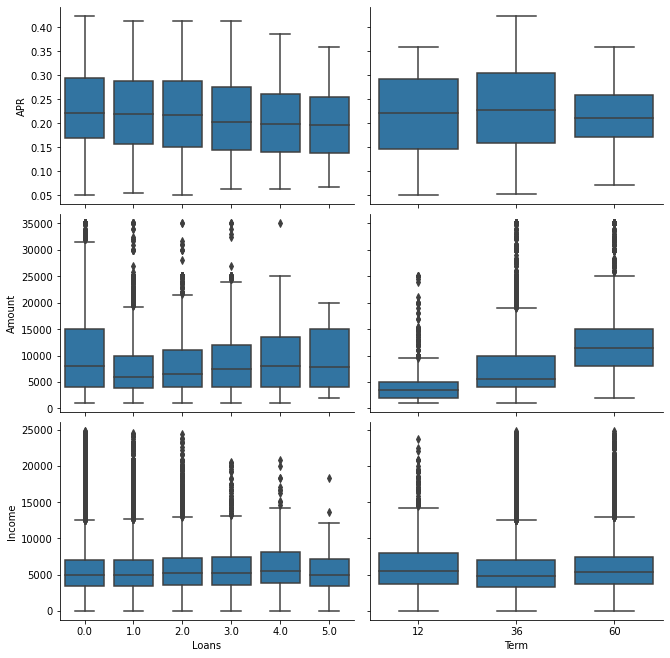

In [23]:
# plot matrix of numeric features against categorical features.

def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    default_color = sb.color_palette()[0]
    sb.boxplot(x, y, color = default_color)

plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = df, y_vars = numeric_vars, x_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(boxgrid)
plt.show();

##### It appears that APR decreases with number of loans but this is because the number of loans is positively correlated to the amount (people who request more loans are generally more rich)


##### C) Categorical variables relations

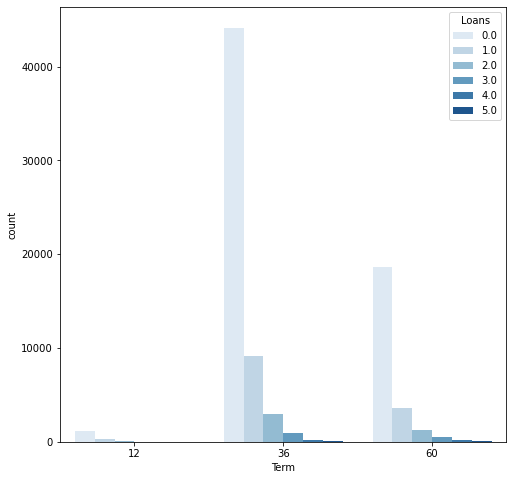

In [24]:
plt.figure(figsize = [8, 8])

# plot 1: term vs number of loans
plt.subplot(1, 1, 1)
sb.countplot(data = df, x = 'Term', hue = 'Loans', palette = 'Blues')

plt.show()

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> APR decreases with increasing monthly income and loan amount which made sense.interestingly APR seem to decrease with number of loans, due to other factors that we'll look at in multivariate exploration.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Loan amount and monthly income are positively correlated,same goes for Term and number of loans.

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

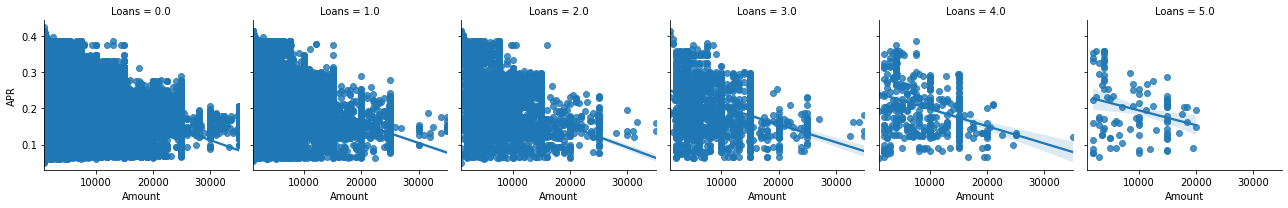

In [25]:
# create faceted heat maps on levels of the Loans variable
g=sb.FacetGrid(data=df, col='Loans')
g.map(sb.regplot, 'Amount', 'APR');
plt.show();

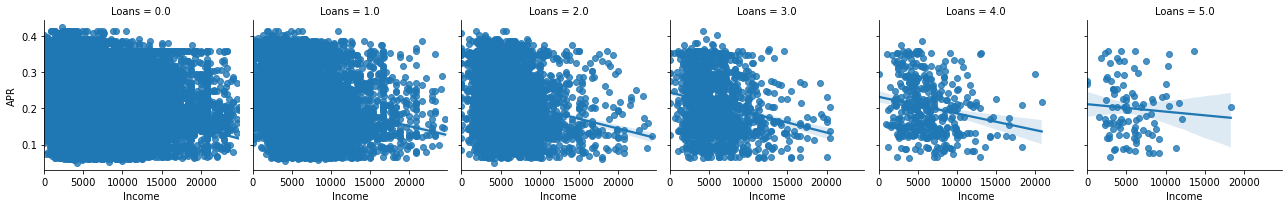

In [26]:
g=sb.FacetGrid(data=df, col='Loans')
g.map(sb.regplot, 'Income', 'APR');
plt.show();

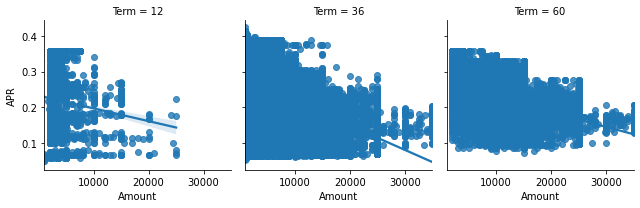

In [27]:
# create faceted heat maps on levels of the Term variable
g=sb.FacetGrid(data=df, col='Term')
g.map(sb.regplot, 'Amount', 'APR');
plt.show();

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Loans number increase relaxes the decrease of the APR with both the Loan's amount and monthly income, the term doesn't seem to have a significant effect but it seems that the 36 months is the one with the least exceptions for the clients (highest APR)

### Were there any interesting or surprising interactions between features?

> As for now all data visualization are up to our expectations, which itself is expected when dealing with Loans data.